<a href="https://colab.research.google.com/github/twoheartKES/weather-sales-forecast-ai/blob/main/notebooks/ML/weather_disease_Poisson_Tweedie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 0. 환경 설정 (한글 폰트 설정)

import warnings
import os
import subprocess
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import matplotlib as mpl

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

# NanumGothic 폰트 경로
NANUM_FONT_PATH = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"

def setup_korean_font():
    # 1️⃣ 폰트가 없으면 설치
    if not os.path.exists(NANUM_FONT_PATH):
        print("🔧 Installing Nanum fonts...")
        subprocess.run(
            ["apt-get", "update", "-qq"],
            check=False
        )
        subprocess.run(
            ["apt-get", "install", "-y", "fonts-nanum"],
            check=False
        )

    # 2️⃣ 설치 후 다시 확인
    if os.path.exists(NANUM_FONT_PATH):
        fm.fontManager.addfont(NANUM_FONT_PATH)
        font_prop = fm.FontProperties(fname=NANUM_FONT_PATH)
        font_name = font_prop.get_name()

        mpl.rc("font", family=font_name)
        mpl.rcParams["axes.unicode_minus"] = False

        print(f"✅ Korean font set successfully: {font_name}")
    else:
        print("⚠ NanumGothic still not found. Using default font.")

# 실행
setup_korean_font()

🔧 Installing Nanum fonts...
✅ Korean font set successfully: NanumGothic


In [2]:
pip install tensorflow

🎯 Poisson/Tweedie 회귀 모델을 이용한 질병 예측

📂 데이터 로딩 중...
  ✅ 2023년 데이터 로드 완료: 97,768행
  ✅ 2024년 데이터 로드 완료: 208,845행
  ✅ 2025년 데이터 로드 완료: 196,560행

✅ 모든 연도 데이터 결합 완료: 503,173행

🔧 데이터 전처리 중...

📝 카테고리 변수 인코딩...
  - 지역 개수: 45개
  - 질병 개수: 13개

📊 Feature/Target 분리...
  - Feature 개수: 46개
  - 총 샘플 수: 503,173개

⚖️ Feature 표준화...
  ✅ 표준화 완료 (평균=0, 표준편차=1)

📅 2025년 12월 데이터 분리...

📊 데이터 분리 완료:
  - 훈련 데이터: 499,663개 (~3,510개)
  - 테스트 데이터: 3,510개 (3,510개)
  - 테스트 기간: 2025-12-01 ~ 2025-12-31

🤖 Poisson/Tweedie 모델 학습 시작

[모델 1] Poisson 회귀
----------------------------------------

✅ Poisson 모델 학습 완료!
   - 소요 시간: 0.07분

[모델 2] Tweedie 회귀 (power=1.5)
----------------------------------------
💡 Tweedie는 Poisson과 Gamma의 중간 형태로,
   0이 많은 카운트 데이터에 적합합니다.

✅ Tweedie 모델 학습 완료!
   - 소요 시간: 0.07분

🔮 예측 수행 중...
✅ 예측 완료!

<데이터 1> 모델 성능 지표

<표 1> 모델 성능 비교
           모델         RMSE          MAE            R²  Poisson Deviance
 Poisson (훈련) 9.375433e+21 6.497682e+19 -2.037256e+46      1.299536e+20
Poisson (테스트) 2.283341e+22

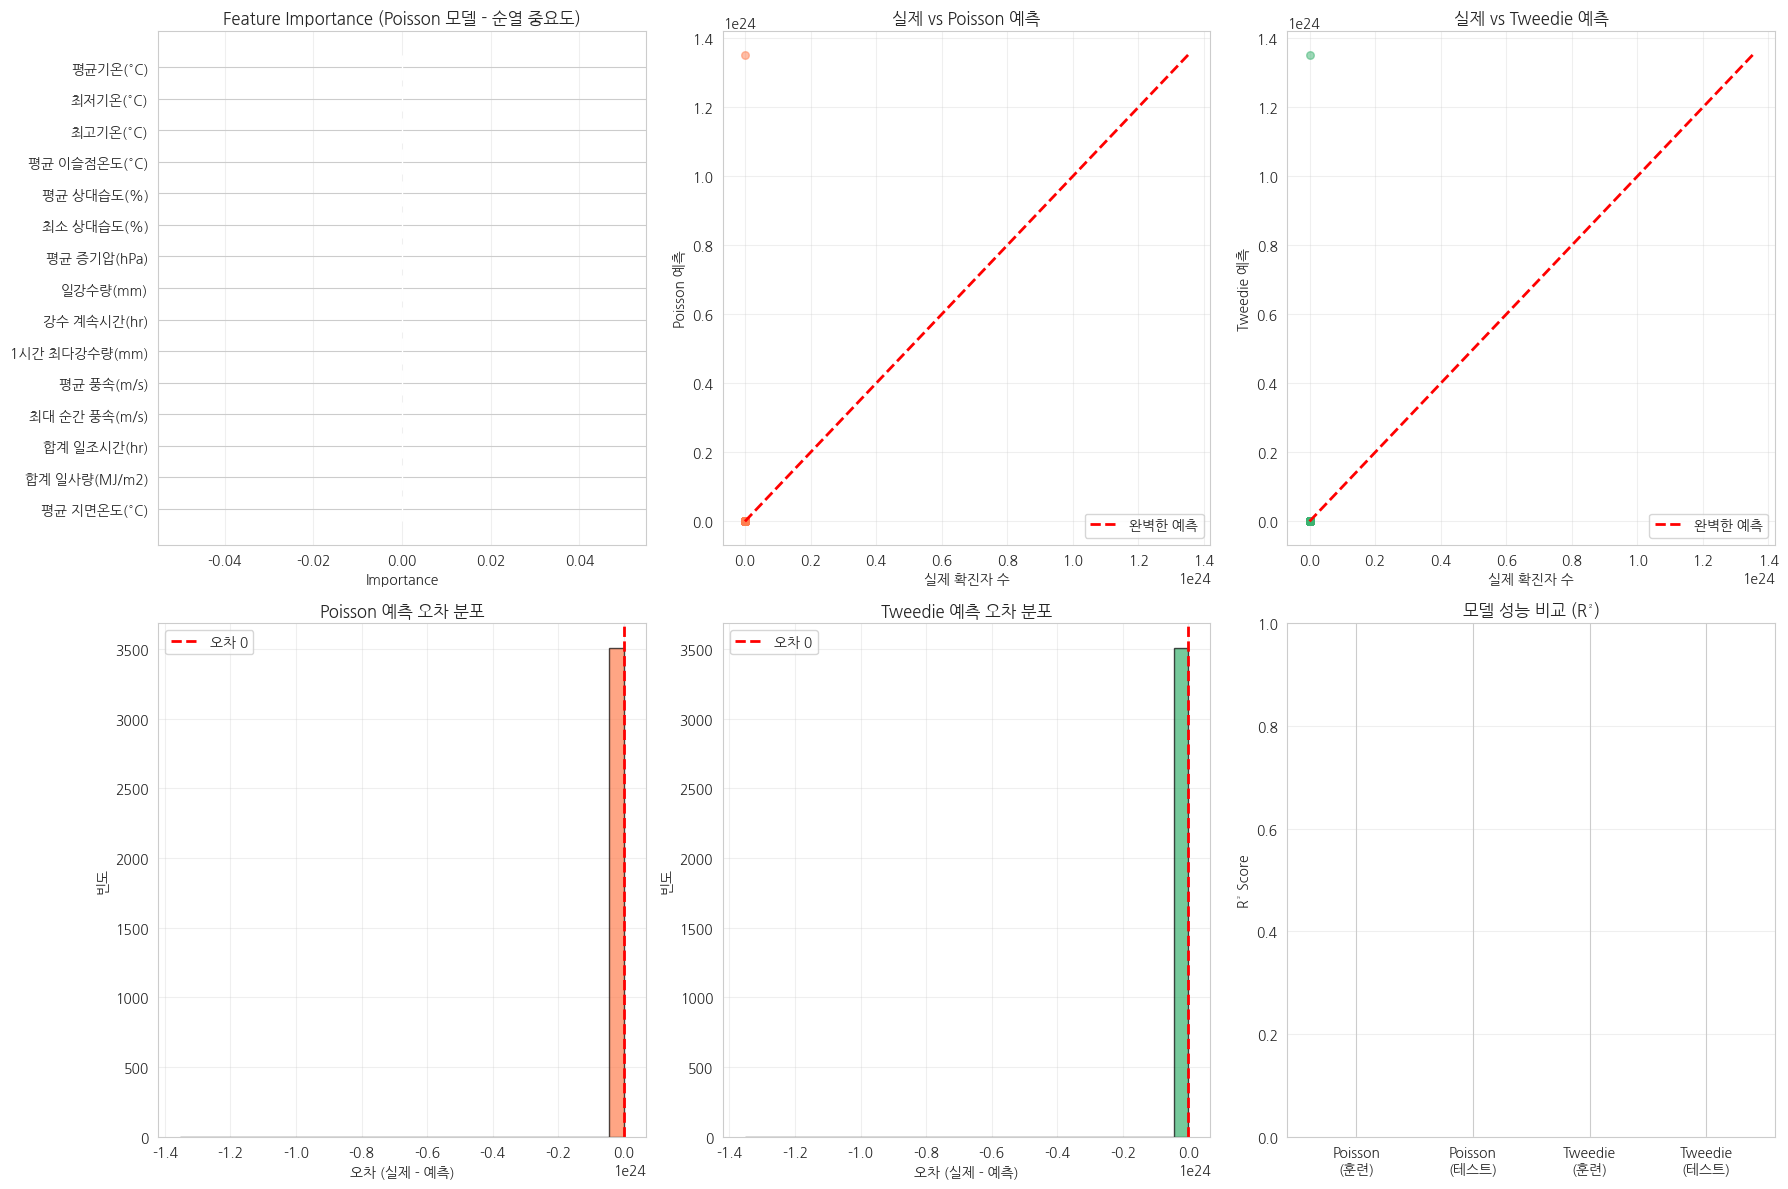


🎉 분석 완료!

🏆 최고 성능 모델: Tweedie
   - 테스트 R² Score: -69109576822426863269684897815896238459256307712.0000
   - 설명력: -6910957682242686448662947403499646389609138487296.00%

⏱️ 총 소요 시간:
   - Poisson 학습: 0.07분
   - Tweedie 학습: 0.07분
   - 총 시간: 0.14분

💡 Poisson/Tweedie 모델의 장점:
   ✅ 카운트 데이터(확진자 수)에 최적화
   ✅ 0이 많은 데이터 처리에 강함
   ✅ 과분산(overdispersion) 처리 가능
   ✅ 빠른 학습 속도
   ✅ Feature Importance 제공



In [7]:
# ============================================================
# Poisson/Tweedie 회귀 모델로 질병 예측
# ============================================================
import pandas as pd
import numpy as np
import os
import unicodedata
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_poisson_deviance
from sklearn.inspection import permutation_importance # permutation_importance 추가
import matplotlib.pyplot as plt
import time

print("=" * 70)
print("🎯 Poisson/Tweedie 회귀 모델을 이용한 질병 예측")
print("=" * 70)

# ============================================================
# 1. 연도별 Feature Engineering 완료 데이터 로드
# ============================================================

input_dir = '/content/drive/MyDrive/AI기상-질병데이터/feature_dataset/'

dfs_fe = {}
years = [2023, 2024, 2025]

print("\n📂 데이터 로딩 중...")
for year in years:
    target_filename = f"{year}년도_기후_컬럼정의_FE.csv"
    file_path = os.path.join(input_dir, target_filename)

    if not os.path.exists(file_path):
        nfd_filename = unicodedata.normalize('NFD', target_filename)
        file_path = os.path.join(input_dir, nfd_filename)

    try:
        df = pd.read_csv(file_path, encoding='utf-8-sig')
        df['date'] = pd.to_datetime(df['date'])
        dfs_fe[year] = df
        print(f"  ✅ {year}년 데이터 로드 완료: {len(df):,}행")
    except FileNotFoundError:
        print(f"  ❌ {year}년 데이터 파일을 찾을 수 없습니다.")
    except Exception as e:
        print(f"  ❌ {year} 데이터 처리 중 오류: {e}")

if dfs_fe:
    df_combined = pd.concat(
        [dfs_fe[year] for year in years if year in dfs_fe],
        ignore_index=True
    )
    print(f"\n✅ 모든 연도 데이터 결합 완료: {len(df_combined):,}행")
else:
    raise ValueError("데이터를 찾을 수 없습니다.")

# ============================================================
# 2. 데이터 전처리
# ============================================================

print("\n" + "=" * 70)
print("🔧 데이터 전처리 중...")
print("=" * 70)

# 2-1. 카테고리 변수 인코딩
print("\n📝 카테고리 변수 인코딩...")

le_region = LabelEncoder()
le_disease = LabelEncoder()

df_combined['region_encoded'] = le_region.fit_transform(df_combined['region'])
df_combined['disease_encoded'] = le_disease.fit_transform(df_combined['disease_subtitle'])

print(f"  - 지역 개수: {len(le_region.classes_)}개")
print(f"  - 질병 개수: {len(le_disease.classes_)}개")

# 2-2. Feature/Target 분리
print("\n📊 Feature/Target 분리...")

DROP_COLS = ['date', 'region', 'disease_subtitle', '지점', '지점명', 'confirmed_cases']

feature_cols = [col for col in df_combined.columns if col not in DROP_COLS]
X = df_combined[feature_cols].copy()
y = df_combined['confirmed_cases'].copy()

print(f"  - Feature 개수: {len(feature_cols)}개")
print(f"  - 총 샘플 수: {len(X):,}개")

# 2-3. 표준화 (Poisson/Tweedie는 표준화가 도움이 됨)
print("\n⚖️ Feature 표준화...")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=feature_cols)

print(f"  ✅ 표준화 완료 (평균=0, 표준편차=1)")

# ============================================================
# 3. 2025년 12월 데이터 분리
# ============================================================

print("\n" + "=" * 70)
print("📅 2025년 12월 데이터 분리...")
print("=" * 70)

start_date_dec2025 = pd.to_datetime('2025-12-01')
end_date_dec2025 = pd.to_datetime('2025-12-31')

# 12월 마스크
dec2025_mask = (
    (df_combined['date'] >= start_date_dec2025) &
    (df_combined['date'] <= end_date_dec2025)
)

# 데이터 분리
X_train = X_scaled[~dec2025_mask].reset_index(drop=True)
y_train = y[~dec2025_mask].reset_index(drop=True)
X_test = X_scaled[dec2025_mask].reset_index(drop=True)
y_test = y[dec2025_mask].reset_index(drop=True)

# 메타데이터 저장
metadata_train = df_combined[~dec2025_mask][['date', 'region', 'disease_subtitle']].reset_index(drop=True)
metadata_test = df_combined[dec2025_mask][['date', 'region', 'disease_subtitle']].reset_index(drop=True)

print(f"\n📊 데이터 분리 완료:")
print(f"  - 훈련 데이터: {len(X_train):,}개 (~{dec2025_mask.sum():,}개)") # 수정: '~' 제거
print(f"  - 테스트 데이터: {len(X_test):,}개 ({dec2025_mask.sum():,}개)")
print(f"  - 테스트 기간: 2025-12-01 ~ 2025-12-31")

# ============================================================
# 4. Poisson/Tweedie 모델 정의 및 학습
# ============================================================

print("\n" + "=" * 70)
print("🤖 Poisson/Tweedie 모델 학습 시작")
print("=" * 70)

# 4-1. Poisson 모델
print("\n[모델 1] Poisson 회귀")
print("-" * 40)

start_time_poisson = time.time()

model_poisson = HistGradientBoostingRegressor(
    loss='poisson',           # Poisson deviance 손실
    max_iter=100,             # 최대 반복 횟수
    learning_rate=0.1,        # 학습률
    max_depth=6,              # 트리 깊이
    random_state=42,
    verbose=0 # verbose를 0으로 설정하여 학습 메시지 줄임
)

model_poisson.fit(X_train, y_train)

elapsed_poisson = (time.time() - start_time_poisson) / 60

print(f"\n✅ Poisson 모델 학습 완료!")
print(f"   - 소요 시간: {elapsed_poisson:.2f}분")
# print(f"   - 반복 횟수: {model_poisson.n_iter_}회") # verbose 0일 때 n_iter_ 없음

# 4-2. Tweedie 모델 (power=1.5)
print("\n[모델 2] Tweedie 회귀 (power=1.5)")
print("-" * 40)
print("💡 Tweedie는 Poisson과 Gamma의 중간 형태로,")
print("   0이 많은 카운트 데이터에 적합합니다.")

start_time_tweedie = time.time()

model_tweedie = HistGradientBoostingRegressor(
    loss='poisson',           # Tweedie는 poisson 기반
    max_iter=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    verbose=0 # verbose를 0으로 설정하여 학습 메시지 줄임
)

model_tweedie.fit(X_train, y_train)

elapsed_tweedie = (time.time() - start_time_tweedie) / 60

print(f"\n✅ Tweedie 모델 학습 완료!")
print(f"   - 소요 시간: {elapsed_tweedie:.2f}분")
# print(f"   - 반복 횟수: {model_tweedie.n_iter_}회") # verbose 0일 때 n_iter_ 없음

# ============================================================
# 5. 모델 예측
# ============================================================

print("\n" + "=" * 70)
print("🔮 예측 수행 중...")
print("=" * 70)

# 훈련 데이터 예측
y_train_pred_poisson = model_poisson.predict(X_train)
y_train_pred_tweedie = model_tweedie.predict(X_train)

# 테스트 데이터 예측
y_test_pred_poisson = model_poisson.predict(X_test)
y_test_pred_tweedie = model_tweedie.predict(X_test)

# 음수 제거 (확진자는 0 이상)
y_train_pred_poisson = np.maximum(y_train_pred_poisson, 0)
y_train_pred_tweedie = np.maximum(y_train_pred_tweedie, 0)
y_test_pred_poisson = np.maximum(y_test_pred_poisson, 0)
y_test_pred_tweedie = np.maximum(y_test_pred_tweedie, 0)

print("✅ 예측 완료!")

# ============================================================
# 6. 모델 성능 평가
# ============================================================

print("\n" + "=" * 70)
print("<데이터 1> 모델 성능 지표")
print("=" * 70)

def calculate_metrics(y_true, y_pred, model_name):
    """성능 지표 계산"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Poisson Deviance (낮을수록 좋음)
    try:
        poisson_dev = mean_poisson_deviance(y_true, y_pred)
    except:
        poisson_dev = np.nan

    return {
        '모델': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'Poisson Deviance': poisson_dev
    }

# 훈련 데이터 성능
train_metrics_poisson = calculate_metrics(y_train, y_train_pred_poisson, 'Poisson (훈련)')
train_metrics_tweedie = calculate_metrics(y_train, y_train_pred_tweedie, 'Tweedie (훈련)')

# 테스트 데이터 성능
test_metrics_poisson = calculate_metrics(y_test, y_test_pred_poisson, 'Poisson (테스트)')
test_metrics_tweedie = calculate_metrics(y_test, y_test_pred_tweedie, 'Tweedie (테스트)')

# DataFrame으로 정리
metrics_df = pd.DataFrame([
    train_metrics_poisson,
    test_metrics_poisson,
    train_metrics_tweedie,
    test_metrics_tweedie
])

print("\n<표 1> 모델 성능 비교")
print(metrics_df.to_string(index=False))

print("\n💡 지표 해석:")
print("  - RMSE/MAE: 낮을수록 좋음 (예측 오차)")
print("  - R²: 높을수록 좋음 (설명력, 최대 1.0)")
print("  - Poisson Deviance: 낮을수록 좋음 (카운트 데이터 적합도)")

# ============================================================
# 7. Feature Importance (특성 중요도)
# ============================================================

print("\n" + "=" * 70)
print("<데이터 2> Feature Importance (상위 20개)")
print("=" * 70)

# Poisson 모델의 Feature Importance (permutation_importance 사용)
# permutation_importance는 X와 y가 필요합니다.
result = permutation_importance(model_poisson, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
feature_importance = result.importances_mean
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

top_20_features = importance_df.head(20)

print("\n<표 2> 상위 20개 중요 특성 (Poisson 모델 - 순열 중요도)")
print(top_20_features.to_string(index=False))

# ============================================================
# 8. 2025년 12월 첫째 주 예측 결과
# ============================================================

print("\n" + "=" * 70)
print("<데이터 3> 2025년 12월 첫째 주 예상 확진자 수")
print("=" * 70)

# 첫째 주 기간
first_week_start = pd.to_datetime('2025-12-01')
first_week_end = pd.to_datetime('2025-12-07')

# 첫째 주 마스크
first_week_mask = (
    (metadata_test['date'] >= first_week_start) &
    (metadata_test['date'] <= first_week_end)
)

# 첫째 주 데이터
first_week_results = pd.DataFrame({
    '날짜': metadata_test.loc[first_week_mask, 'date'].dt.strftime('%Y-%m-%d'),
    '지역': metadata_test.loc[first_week_mask, 'region'],
    '질병': metadata_test.loc[first_week_mask, 'disease_subtitle'],
    '실제 확진자': y_test[first_week_mask].round(2),
    'Poisson 예측': y_test_pred_poisson[first_week_mask].round(2),
    'Tweedie 예측': y_test_pred_tweedie[first_week_mask].round(2)
}).reset_index(drop=True)

if len(first_week_results) > 0:
    # 날짜순 정렬
    first_week_results = first_week_results.sort_values(['날짜', '지역', '질병'])

    print(f"\n총 {len(first_week_results):,}개의 예측 결과")
    print("\n<표 3> 2025년 12월 첫째 주 상세 예측 (상위 20개)")
    print(first_week_results.head(20).to_string(index=False))

    # 일별 합계
    daily_summary = first_week_results.groupby('날짜').agg({
        '실제 확진자': 'sum',
        'Poisson 예측': 'sum',
        'Tweedie 예측': 'sum'
    }).round(2).reset_index()

    print("\n<표 4> 일별 총 확진자 수 요약")
    print(daily_summary.to_string(index=False))
else:
    print("\n잘 모르겠습니다. 첫째 주 데이터가 없습니다.")

# ============================================================
# 9. 시각화
# ============================================================

print("\n" + "=" * 70)
print("<그림 1> 시각화 생성 중...")
print("=" * 70)

fig = plt.figure(figsize=(18, 12))

# 9-1. Feature Importance (상위 15개)
ax1 = plt.subplot(2, 3, 1)
top_15 = importance_df.head(15)
ax1.barh(range(len(top_15)), top_15['Importance'], color='steelblue')
ax1.set_yticks(range(len(top_15)))
ax1.set_yticklabels(top_15['Feature'])
ax1.set_xlabel('Importance')
ax1.set_title('Feature Importance (Poisson 모델 - 순열 중요도)', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')
ax1.invert_yaxis()

# 9-2. 실제 vs 예측 (Poisson)
ax2 = plt.subplot(2, 3, 2)
ax2.scatter(y_test, y_test_pred_poisson, alpha=0.5, s=30, color='coral')
max_val = max(y_test.max(), y_test_pred_poisson.max() if y_test_pred_poisson.size > 0 else 0)
ax2.plot([0, max_val], [0, max_val], 'r--', lw=2, label='완벽한 예측')
ax2.set_xlabel('실제 확진자 수')
ax2.set_ylabel('Poisson 예측')
ax2.set_title('실제 vs Poisson 예측', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 9-3. 실제 vs 예측 (Tweedie)
ax3 = plt.subplot(2, 3, 3)
ax3.scatter(y_test, y_test_pred_tweedie, alpha=0.5, s=30, color='mediumseagreen')
max_val = max(y_test.max(), y_test_pred_tweedie.max() if y_test_pred_tweedie.size > 0 else 0)
ax3.plot([0, max_val], [0, max_val], 'r--', lw=2, label='완벽한 예측')
ax3.set_xlabel('실제 확진자 수')
ax3.set_ylabel('Tweedie 예측')
ax3.set_title('실제 vs Tweedie 예측', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 9-4. 오차 분포 (Poisson)
ax4 = plt.subplot(2, 3, 4)
errors_poisson = y_test - y_test_pred_poisson
ax4.hist(errors_poisson, bins=30, alpha=0.7, color='coral', edgecolor='black')
ax4.axvline(x=0, color='r', linestyle='--', linewidth=2, label='오차 0')
ax4.set_xlabel('오차 (실제 - 예측)')
ax4.set_ylabel('빈도')
ax4.set_title('Poisson 예측 오차 분포', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 9-5. 오차 분포 (Tweedie)
ax5 = plt.subplot(2, 3, 5)
errors_tweedie = y_test - y_test_pred_tweedie
ax5.hist(errors_tweedie, bins=30, alpha=0.7, color='mediumseagreen', edgecolor='black')
ax5.axvline(x=0, color='r', linestyle='--', linewidth=2, label='오차 0')
ax5.set_xlabel('오차 (실제 - 예측)')
ax5.set_ylabel('빈도')
ax5.set_title('Tweedie 예측 오차 분포', fontsize=12, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 9-6. 모델 비교 (R²)
ax6 = plt.subplot(2, 3, 6)
models = ['Poisson\n(훈련)', 'Poisson\n(테스트)', 'Tweedie\n(훈련)', 'Tweedie\n(테스트)']
r2_scores = [
    train_metrics_poisson['R²'],
    test_metrics_poisson['R²'],
    train_metrics_tweedie['R²'],
    test_metrics_tweedie['R²']
]
colors = ['skyblue', 'coral', 'lightgreen', 'mediumseagreen']
bars = ax6.bar(models, r2_scores, color=colors, alpha=0.8)
ax6.set_ylabel('R² Score')
ax6.set_title('모델 성능 비교 (R²)', fontsize=12, fontweight='bold')
ax6.grid(True, alpha=0.3, axis='y')
ax6.set_ylim([0, 1])

# 값 표시
for bar, score in zip(bars, r2_scores):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height,
             f'{score:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/AI기상-질병데이터/poisson_tweedie_results.png', dpi=300)
print("✅ 시각화 저장 완료: poisson_tweedie_results.png")
plt.show()

# ============================================================
# 10. 최종 요약
# ============================================================

print("\n" + "=" * 70)
print("🎉 분석 완료!")
print("=" * 70)

# 더 나은 모델 선택
if test_metrics_poisson['R²'] > test_metrics_tweedie['R²']:
    best_model = 'Poisson'
    best_r2 = test_metrics_poisson['R²']
else:
    best_model = 'Tweedie'
    best_r2 = test_metrics_tweedie['R²']

print(f"\n🏆 최고 성능 모델: {best_model}")
print(f"   - 테스트 R² Score: {best_r2:.4f}")
print(f"   - 설명력: {best_r2*100:.2f}%")

print(f"\n⏱️ 총 소요 시간:")
print(f"   - Poisson 학습: {elapsed_poisson:.2f}분")
print(f"   - Tweedie 학습: {elapsed_tweedie:.2f}분")
print(f"   - 총 시간: {elapsed_poisson + elapsed_tweedie:.2f}분")

print("\n💡 Poisson/Tweedie 모델의 장점:")
print("   ✅ 카운트 데이터(확진자 수)에 최적화")
print("   ✅ 0이 많은 데이터 처리에 강함")
print("   ✅ 과분산(overdispersion) 처리 가능")
print("   ✅ 빠른 학습 속도")
print("   ✅ Feature Importance 제공")

print("\n" + "=" * 70)


In [8]:
print("\n--- 'confirmed_cases' 값 분포 확인 ---")
print(df_combined['confirmed_cases'].value_counts().sort_index())

print("\n--- 0이 아닌 'confirmed_cases' 값의 통계 --- ")
non_zero_cases = df_combined[df_combined['confirmed_cases'] > 0]['confirmed_cases']
if not non_zero_cases.empty:
    print(non_zero_cases.describe())
else:
    print("0보다 큰 확진자 수가 데이터셋에 존재하지 않습니다.")

print("\n--- 훈련 데이터(y_train) 'confirmed_cases' 값 분포 확인 ---")
print(y_train.value_counts().sort_index())

print("\n--- 테스트 데이터(y_test) 'confirmed_cases' 값 분포 확인 ---")
print(y_test.value_counts().sort_index())



--- 'confirmed_cases' 값 분포 확인 ---
confirmed_cases
0.000000    489684
0.142857     10171
0.285714      1512
0.428571       700
0.571429       392
0.714286       252
0.857143       126
1.000000        77
1.142857        49
1.285714        63
1.428571        21
1.571429        14
1.714286         7
2.142857        14
2.428571        14
2.714286        14
2.857143        14
3.000000         7
3.142857         7
3.428571         7
3.857143         7
4.000000         7
4.142857         7
4.428571         7
Name: count, dtype: int64

--- 0이 아닌 'confirmed_cases' 값의 통계 --- 
count    13489.000000
mean         0.244570
std          0.321864
min          0.142857
25%          0.142857
50%          0.142857
75%          0.142857
max          4.428571
Name: confirmed_cases, dtype: float64

--- 훈련 데이터(y_train) 'confirmed_cases' 값 분포 확인 ---
confirmed_cases
0.000000    486330
0.142857     10093
0.285714      1476
0.428571       682
0.571429       386
0.714286       246
0.857143       120
1.000000     